In [1]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm

from statsmodels.tsa.stattools import adfuller, kpss

from factor_analyzer import FactorAnalyzer

In [2]:
import sys
sys.path.append('../') # go to parent dir
sys.path.append('/home/artem/git/sdafe')

In [3]:
from sdafe.plot import abs_diff_heatmap
from sdafe.ch12.unitroot import adf_test
from sdafe.ch18.pca import princomp
from sdafe.ch18.factors import bootstrap_corr, estimate_corr, sufficiency_test, evaluate_factors

### 18.8.1 PCA

In [4]:
data = pd.read_csv('../data/yields.txt', sep='\\s+')
data.head()

,1mon,2mon,3mon,4mon,5mon,5.5mon,6.5mon,7.5mon,8.5mon,9.5mon,NA
0,5.59957,7.22989,7.60820,7.72886,7.75856,7.74944,7.73191,7.71845,7.75699,7.79656,7.80871
1,5.63497,7.17471,7.51762,7.65834,7.69625,7.68582,7.67083,7.66179,7.69745,7.74334,7.75632
2,5.61633,7.20652,7.55039,7.71713,7.75815,7.74095,7.72610,7.71934,7.75459,7.79603,7.80092
3,5.71211,7.20071,7.54165,7.71308,7.76433,7.74835,7.73323,7.72261,7.74459,7.78738,7.79996
4,5.78938,7.19130,7.56918,7.73931,7.78977,7.77982,7.76339,7.73900,7.77044,7.80845,7.81773


In [5]:
maturity = list(range(6)) + [5.5, 6.5, 7.5, 8.5, 9.5]
data.columns = maturity

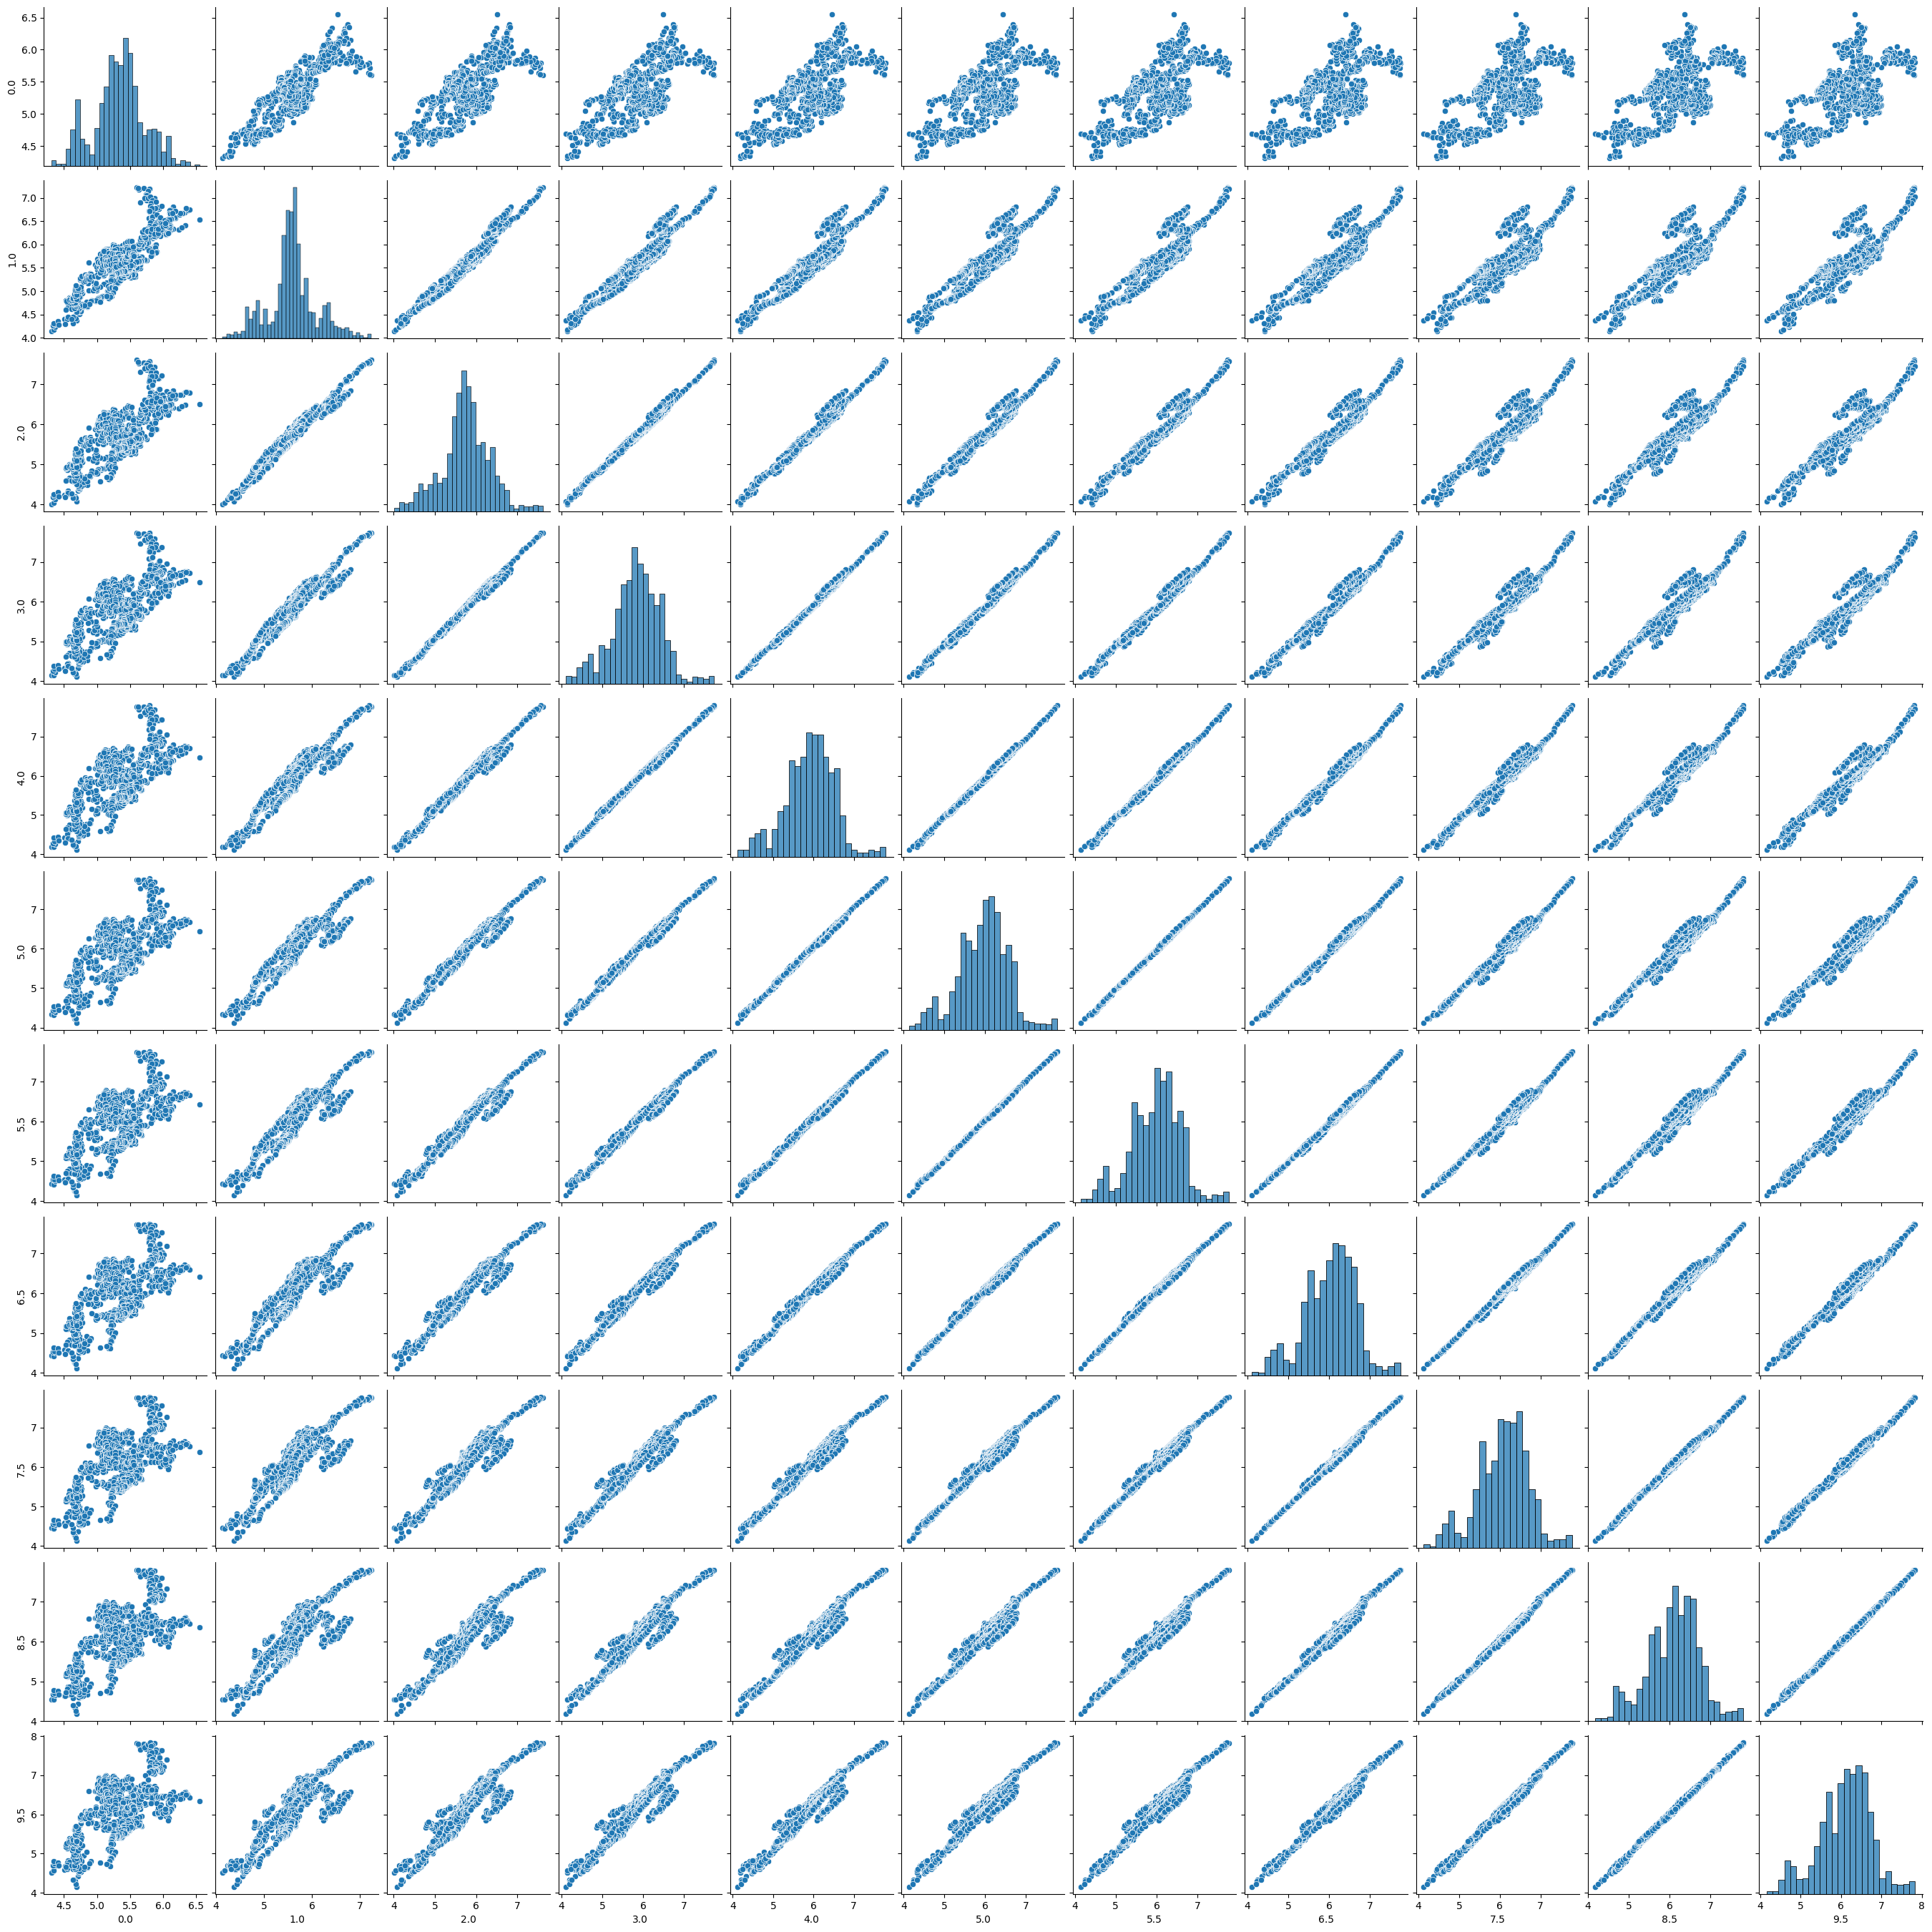

In [6]:
sns.pairplot(data);

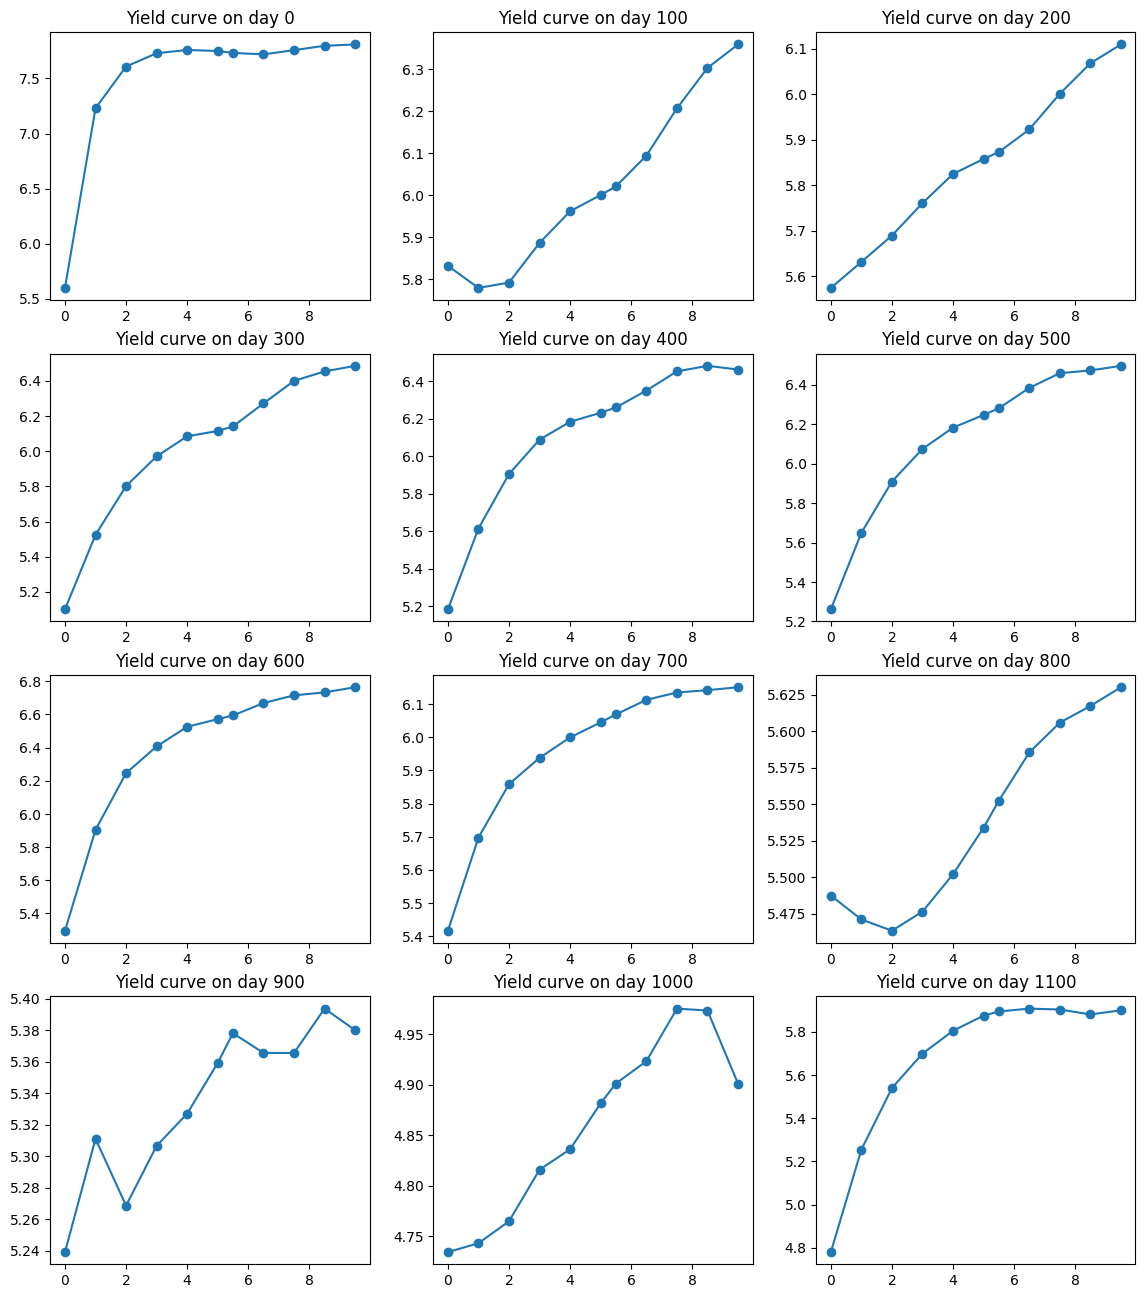

In [7]:
fig, axs = plt.subplots(4, 3, figsize=(14, 16))
for i in range(12):
    axs[i // 3][i % 3].plot(data.columns, data.iloc[i * 100, :], '-o');
    axs[i // 3][i % 3].set_title(f'Yield curve on day {i * 100}');

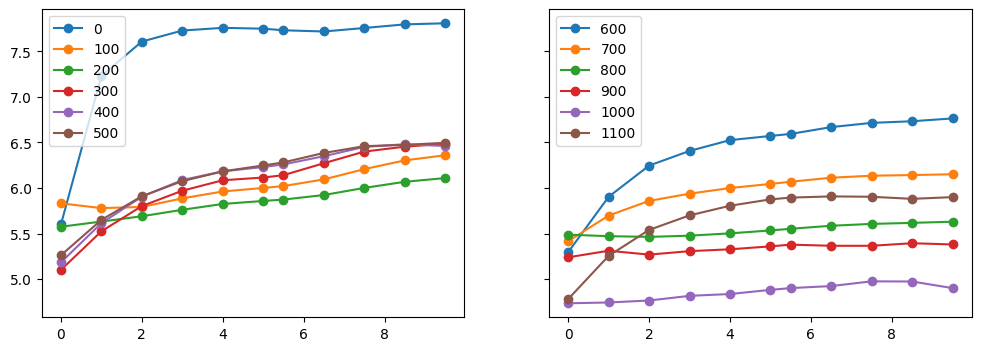

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
for i in range(6):
    axs[0].plot(data.columns, data.iloc[i * 100, :], '-o', label=str(i * 100));
    axs[0].legend();
for i in range(6, 12):
    axs[1].plot(data.columns, data.iloc[i * 100, :], '-o', label=str(i * 100));
    axs[1].legend();

In [9]:
w, v = np.linalg.eig(np.cov(data, rowvar=False, ddof=1))
order = np.flip(np.argsort(w))
v = v[:, order]
w = w[order]

In [10]:
w

array([3.71791147e+00, 1.48224231e-01, 3.23202321e-02, 2.73932002e-03,
       7.46760237e-04, 6.06000184e-04, 2.81925195e-04, 1.06977676e-04,
       7.35290533e-05, 2.62756598e-05, 6.49005797e-06])

In [11]:
pd.DataFrame(v)

,0,1,2,3,4,5,6,7,8,9,10
0,-0.130111,-0.678872,-0.610143,-0.336543,0.137272,0.130297,-0.009156,0.022890,0.006856,-0.012994,0.004823
1,-0.243209,-0.475173,0.131224,0.450033,-0.397674,-0.494935,-0.187014,-0.236828,0.026961,0.000369,-0.020392
2,-0.300325,-0.265751,0.303979,0.202653,0.138538,0.085775,0.507612,0.540432,-0.329863,0.133077,0.053887
3,-0.315385,-0.124258,0.267819,0.167741,0.327383,0.310427,-0.074001,-0.016018,0.633382,-0.393362,-0.141580
4,-0.322511,-0.024759,0.198023,-0.014350,0.247030,0.315067,-0.110711,-0.573244,-0.200066,0.451496,0.333051
5,-0.321120,0.033978,0.185861,-0.311433,-0.217988,0.183365,-0.190505,-0.081345,-0.398540,-0.155467,-0.676120
6,-0.319003,0.063081,0.164732,-0.402971,-0.379893,0.022421,-0.289017,0.300759,0.046600,-0.214357,0.581211
7,-0.324451,0.145820,0.030428,-0.409014,-0.018034,-0.408122,0.297956,-0.003114,0.446855,0.458537,-0.199094
8,-0.325770,0.231545,-0.170284,-0.037273,0.448264,-0.482040,0.120221,-0.180300,-0.289156,-0.478699,0.129796
9,-0.324332,0.262721,-0.356100,0.335965,0.175882,-0.011468,-0.529151,0.402095,-0.012512,0.317891,-0.110217


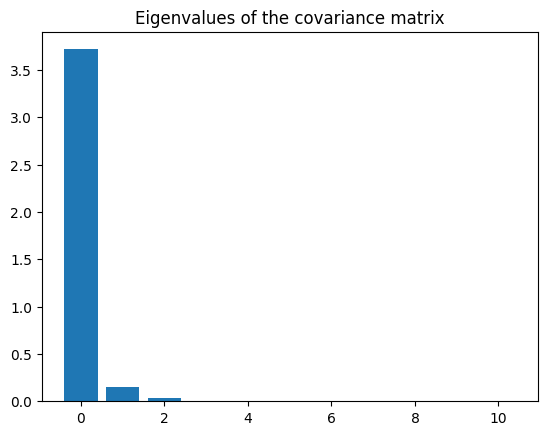

In [12]:
fig, ax = plt.subplots()
ax.bar(range(len(w)), height=w);
ax.set_title('Eigenvalues of the covariance matrix');

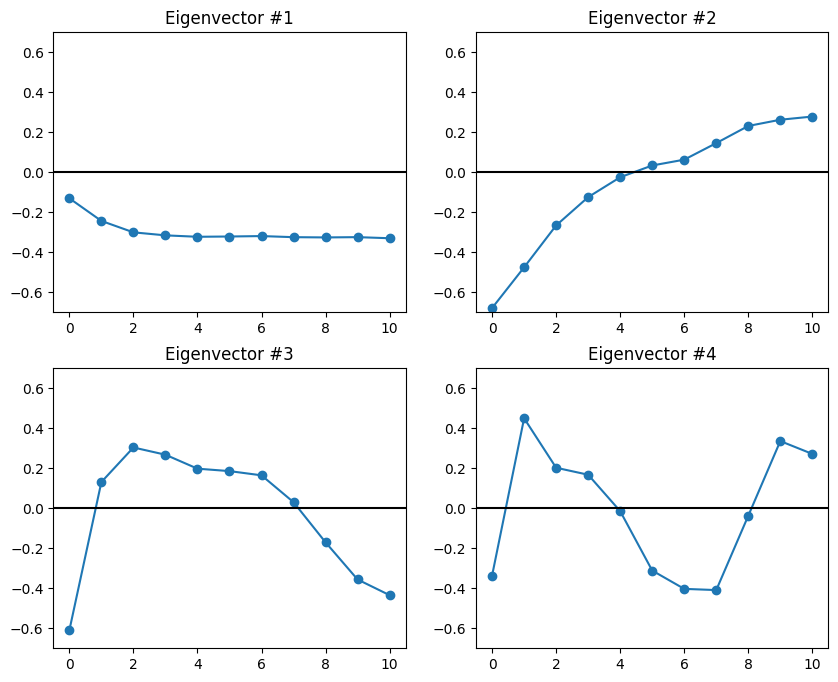

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
for i in range(4):
    axs[i // 2][i % 2].plot(v[:, i], '-o');
    axs[i // 2][i % 2].set_title(f'Eigenvector #{i+1}');
    axs[i // 2][i % 2].set_ylim((-0.7, 0.7));
    axs[i // 2][i % 2].axhline(0, color='black');

#### Problem 1

It is difficult to conclude from the plot of the short-term interest rate whether the process is stationary.

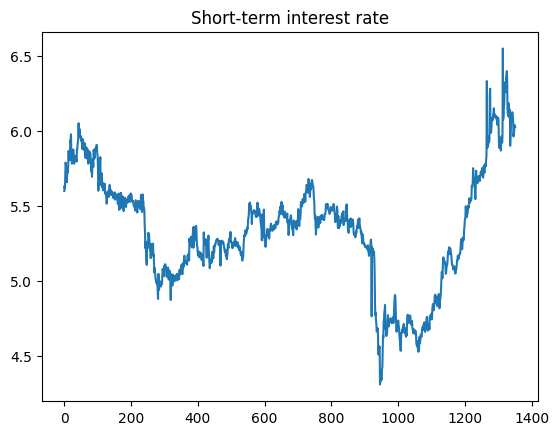

In [14]:
fig, ax = plt.subplots()
ax.plot(data.iloc[:, 0]);
ax.set_title('Short-term interest rate');

#### Problem 2

The augmented Dickey-Fuller test does not reject the null hypothesis of a unit root:

In [15]:
adf_test(data.iloc[:, 0])

(-1.085540474191335,
 0.9314482900628848,
 11,
 1340,
 {'1%': -3.96554193256609, '5%': -3.4137714690695, '10%': -3.1289817474390134})

#### Problem 3

In [16]:
delta_yield = data.diff().dropna()

The plot of the change in the short-term interest rate appears stationary, with some evidence of volatility clustering:

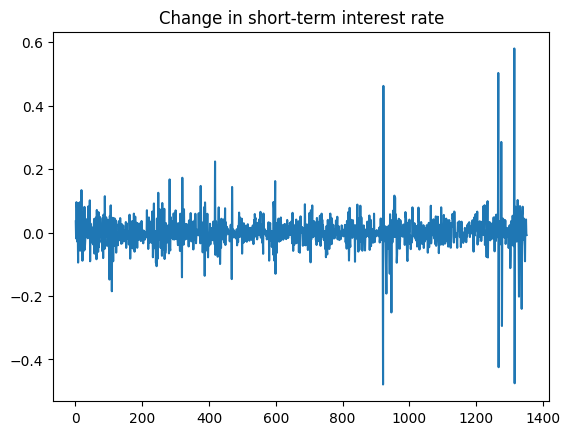

In [17]:
fig, ax = plt.subplots()
ax.plot(delta_yield.iloc[:, 0]);
ax.set_title('Change in short-term interest rate');

The augmented Dickey-Fuller test rejects the null hypothesis of a unit root, thus suggesting the time series is stationary:

In [18]:
adf_test(delta_yield.iloc[:, 0])

(-11.00717808229995,
 2.1569281818439174e-17,
 11,
 1339,
 {'1%': -3.965547001937308,
  '5%': -3.4137739235451434,
  '10%': -3.12898319176582})

In [19]:
res = princomp(delta_yield)
res.summary()

,Comp.1,Comp.2,Comp.3,Comp.4,Comp.5,Comp.6,Comp.7,Comp.8,Comp.9,Comp.10,Comp.11
Standard deviation,0.176884,0.053334,0.032005,0.014443,0.011030,0.008846,0.008090,0.006356,0.004281,0.003737,0.001975
Proportion of Variance,0.876233,0.079663,0.028686,0.005842,0.003407,0.002192,0.001833,0.001131,0.000513,0.000391,0.000109
Cumulative Proportion,0.876233,0.955896,0.984582,0.990423,0.993830,0.996022,0.997855,0.998986,0.999500,0.999891,1.000000


#### Problem 4

(a) The outputs are as follows:
   * `sdev`: the standard deviations of the principal components, i.e. the square roots of the eigenvalues of the covariance matrix,
   * `loadings`: the principal component loadings, i.e. the eigenvectors of the covariance matrix,
   * `center`: the means of the variables in the input data,
   * `scores`: the projections of the demeaned input data points onto the principal components.

(b) The first two eigenvalues are:

In [20]:
res.sdev[:2] ** 2

array([0.03128787, 0.00284453])

(c) The eigenvector corresponding to the largest eigenvalue is:

In [21]:
res.loadings[0]

array([-0.06464327, -0.95213812, -0.21208373,  0.18327026,  0.06114526,
       -0.01658223, -0.07932921, -0.01041008,  0.00813943, -0.01387013,
        0.00359444])

(d) The number of principal components sufficient to explain a given proportion of variance:

In [22]:
(np.arange(len(res.sdev)) + 1)[res.summary().loc['Cumulative Proportion'] >= 0.95][0]

2

### 18.8.2 Fitting Factor Models by Time Series Regression

In [23]:
data = pd.read_csv('../data/Stock_Bond_2004_to_2006.csv', index_col=1, parse_dates=[1])
data.head()

,Date,Three_month_treasury,GM_Volume,GM_AC,F_Volume,F_AC,UTX_Volume,UTX_AC,CAT_Volume,CAT_AC,...,S&P_Volume,1 year Treasury Constant Maturity Rate,3-Year Treasury Constant Maturity Rate,10 year Treasury Constant Maturity Rate,30 year Treasury Constant Maturity Rate,Aaa Bond Yield,Baa Bond Yield,$/Euro,Yen/$,Brazil Real/$
DATE,,,,,,,,,,,,,,,,,,,,,
2004-01-02,2-Jan-04,0.91,4660000,46.72,9030400,14.55,3227600,45.13,4172800,39.35,...,1153200000,1.31,2.47,4.38,NaN,5.73,6.70,1.2592,106.95,2.8840
2004-01-05,5-Jan-04,0.90,7324400,47.55,20069800,15.02,3031000,45.40,6184200,40.42,...,1578200064,1.35,2.51,4.41,NaN,5.70,6.68,1.2679,106.10,2.8580
2004-01-06,6-Jan-04,0.90,4793800,47.26,16760800,14.97,3754200,45.29,6190400,39.70,...,1494499968,1.30,2.38,4.29,NaN,5.63,6.61,1.2773,106.20,2.8575
2004-01-07,7-Jan-04,0.89,8304600,47.91,13801900,15.38,3413200,45.43,6203200,39.27,...,1704899968,1.29,2.36,4.27,NaN,5.61,6.57,1.2665,106.19,2.8690
2004-01-08,8-Jan-04,0.86,8282800,47.90,15805300,15.48,3793200,45.38,4844400,38.97,...,1868400000,1.29,2.37,4.27,NaN,5.63,6.53,1.2772,106.17,2.8500


In [24]:
stock_prices = data.loc['2004-01-01':'2005-12-31', ['GM_AC', 'F_AC', 'UTX_AC', 'MRK_AC']]
stock_prices.columns = ['GM', 'F', 'UTX', 'MRK']

In [25]:
data = pd.read_csv('../data/FamaFrenchDaily.txt', sep='\\s+', index_col=0, parse_dates=[0])
data.head()

,Mkt-RF,SMB,HML,RF
date,,,,
1963-07-01,-0.66,0.16,-0.32,0.012
1963-07-02,0.78,-0.28,0.26,0.012
1963-07-03,0.63,-0.18,-0.10,0.012
1963-07-05,0.40,0.09,-0.29,0.012
1963-07-08,-0.62,0.05,-0.20,0.012


In [26]:
ff_data = data.loc['2004-01-05':'2005-12-31']

In [27]:
excess_ret = (np.log(stock_prices).diff() * 100).subtract(ff_data['RF'], axis=0).dropna()

In [28]:
capm_fits = []
for col in excess_ret.columns:
    fit = sm.OLS(excess_ret[col], sm.add_constant(ff_data['Mkt-RF'])).fit()
    capm_fits.append(fit)

    print(f'{" " + col + " ":*^78}')
    print()
    print(fit.summary())
    print()
    print()

************************************* GM *************************************

                            OLS Regression Results                            
Dep. Variable:                     GM   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     96.41
Date:                Sat, 22 Apr 2023   Prob (F-statistic):           6.25e-21
Time:                        17:43:54   Log-Likelihood:                -1045.2
No. Observations:                 503   AIC:                             2094.
Df Residuals:                     501   BIC:                             2103.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

#### Problem 5

The p-values for the intercept estimates are as follows:

In [29]:
pd.DataFrame({'p-value': [fit.pvalues[0] for fit in capm_fits]}, index=excess_ret.columns)

,p-value
GM,0.008329
F,0.006852
UTX,0.954995
MRK,0.334934


Therefore, at 2.5%, we reject the null hypothesis of zero intercept for GM and F, and do not reject it for UTX and MRK.

The presence of a non-zero intercept contradicts the assumptions of CAPM.

#### Problem 6

In [30]:
resid = pd.DataFrame({col: fit.resid for col, fit in zip(excess_ret.columns, capm_fits)})

In [31]:
est, *confints = bootstrap_corr(resid)

The correlation estimate:

In [32]:
est

,GM,F,UTX,MRK
GM,1.000000,0.520165,-0.010045,-0.087756
F,0.520165,1.000000,-0.023762,-0.009579
UTX,-0.010045,-0.023762,1.000000,-0.005503
MRK,-0.087756,-0.009579,-0.005503,1.000000


The lower bounds of correlation estimates:

In [33]:
confints[0]

,GM,F,UTX,MRK
GM,1.000000,0.437242,-0.080937,-0.194611
F,0.437242,1.000000,-0.138444,-0.101434
UTX,-0.080937,-0.138444,1.000000,-0.105161
MRK,-0.194611,-0.101434,-0.105161,1.000000


The upper bounds of correlation estimates:

In [34]:
confints[1]

,GM,F,UTX,MRK
GM,1.000000,0.605607,0.060311,-0.001958
F,0.605607,1.000000,0.099203,0.051654
UTX,0.060311,0.099203,1.000000,0.067226
MRK,-0.001958,0.051654,0.067226,1.000000


For correlations between GM and F, and GM and MRK we cannot accept the hypothesis of zero correlation:

In [35]:
(confints[0] <= 0) & (confints[1] >= 0)

,GM,F,UTX,MRK
GM,False,False,True,False
F,False,False,True,True
UTX,True,True,False,True
MRK,False,True,True,False


In [36]:
estimate_corr(resid)

,Variable1,Variable2,Correlation,Lower bound,Upper bound,p-value
0,GM,F,0.520165,0.453353,0.581163,3.240171e-36
1,GM,UTX,-0.010045,-0.097388,0.077451,8.221845e-01
2,GM,MRK,-0.087756,-0.173851,-0.000330,4.917610e-02
3,F,UTX,-0.023762,-0.110960,0.063799,5.949553e-01
4,F,MRK,-0.009579,-0.096927,0.077914,8.303054e-01
5,UTX,MRK,-0.005503,-0.092886,0.081965,9.020232e-01


#### Problem 7

In [37]:
sigma_market = np.std(ff_data['Mkt-RF'], ddof=1)

In [38]:
betas = np.fromiter((fit.params[1] for fit in capm_fits), float).reshape(-1, 1)
sigma_eps = np.sqrt(np.fromiter((fit.mse_resid for fit in capm_fits), float))

The CAPM covariance matrix estimate:

In [39]:
pd.DataFrame(betas @ betas.T * sigma_market ** 2 + np.diag(sigma_eps ** 2), index=excess_ret.columns, columns=excess_ret.columns)

,GM,F,UTX,MRK
GM,4.471567,0.760516,0.529858,0.360483
F,0.760516,3.094243,0.559329,0.380534
UTX,0.529858,0.559329,1.146551,0.265121
MRK,0.360483,0.380534,0.265121,4.431302


The sample covariance matrix:

In [40]:
excess_ret.cov(ddof=1)

,GM,F,UTX,MRK
GM,4.464094,2.282494,0.512966,0.010753
F,2.282494,3.089678,0.528099,0.350697
UTX,0.512966,0.528099,1.145043,0.255271
MRK,0.010753,0.350697,0.255271,4.422834


The large discrepancies are in the covariances between GM and F, and GM and MRK - consistent with the results in the preceding problem.

#### Problem 8

CAPM assumes that there is only one risk factor, and that market participants are only compenstated by means of return for taking on that risk. If a coefficient in front of other factors is non-zero, that means one is compensated for taking or avoiding some other risk.

At 2.5%, we reject the null hypothesis of zero beta for HML in GM, SMB in UTX and HML in MRK.

In [41]:
fama_fits = []
for col in excess_ret.columns:
    fit = sm.OLS(excess_ret[col], sm.add_constant(ff_data[['Mkt-RF', 'SMB', 'HML']])).fit()
    fama_fits.append(fit)

    print(f'{" " + col + " ":*^78}')
    print()
    print(fit.summary())
    print()
    print()

************************************* GM *************************************

                            OLS Regression Results                            
Dep. Variable:                     GM   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.168
Method:                 Least Squares   F-statistic:                     34.86
Date:                Sat, 22 Apr 2023   Prob (F-statistic):           1.81e-20
Time:                        17:43:57   Log-Likelihood:                -1041.6
No. Observations:                 503   AIC:                             2091.
Df Residuals:                     499   BIC:                             2108.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

#### Problem 9

In [42]:
resid = pd.DataFrame({col: fit.resid for col, fit in zip(excess_ret.columns, fama_fits)})

In [43]:
est, *confints = bootstrap_corr(resid)

The estimated correlation matrix of residuals is:

In [44]:
est

,GM,F,UTX,MRK
GM,1.000000,0.517015,-0.018521,-0.077819
F,0.517015,1.000000,-0.025771,0.000729
UTX,-0.018521,-0.025771,1.000000,-0.013596
MRK,-0.077819,0.000729,-0.013596,1.000000


The lower and upper bounds of the confidence intervals are:

In [45]:
confints[0]

,GM,F,UTX,MRK
GM,1.000000,0.432939,-0.090662,-0.177762
F,0.432939,1.000000,-0.140108,-0.089719
UTX,-0.090662,-0.140108,1.000000,-0.112729
MRK,-0.177762,-0.089719,-0.112729,1.000000


In [46]:
confints[1]

,GM,F,UTX,MRK
GM,1.000000,0.603348,0.054843,0.005511
F,0.603348,1.000000,0.094772,0.058992
UTX,0.054843,0.094772,1.000000,0.059869
MRK,0.005511,0.058992,0.059869,1.000000


In [47]:
(confints[0] <= 0) & (confints[1] >= 0)

,GM,F,UTX,MRK
GM,False,False,True,True
F,False,False,True,True
UTX,True,True,False,True
MRK,True,True,True,False


In [48]:
estimate_corr(resid)

,Variable1,Variable2,Correlation,Lower bound,Upper bound,p-value
0,GM,F,0.517015,0.449924,0.578303,9.985180e-36
1,GM,UTX,-0.018521,-0.105778,0.069019,6.785873e-01
2,GM,MRK,-0.077819,-0.164130,0.009676,8.123015e-02
3,F,UTX,-0.025771,-0.112945,0.061797,5.641865e-01
4,F,MRK,0.000729,-0.086705,0.088152,9.869895e-01
5,UTX,MRK,-0.013596,-0.100905,0.073920,7.609844e-01


At 95% confidence, we cannot accept the hypothesis that the correlation between GM and F is zero.

#### Problem 10

Comparing the models by AIC and BIC is inconclusive:

In [49]:
pd.DataFrame([[capm_fit.aic, fama_fit.aic, capm_fit.bic, fama_fit.bic] for capm_fit, fama_fit in zip(capm_fits, fama_fits)], 
             index=excess_ret.columns,
             columns=pd.MultiIndex.from_tuples([('AIC', 'CAPM'), ('AIC', 'Fama-French'), ('BIC', 'CAPM'), ('BIC', 'Fama-French')], names=['Criterion', 'Model']))

Criterion          AIC                       BIC             
Model             CAPM  Fama-French         CAPM  Fama-French
GM         2094.442013  2091.261560  2102.883193  2108.143921
F          1846.522765  1847.713168  1854.963945  1864.595529
UTX        1289.324921  1284.685986  1297.766101  1301.568347
MRK        2157.358376  2147.936099  2165.799557  2164.818460

#### Problem 11

The covariance matrix of the Fama-French factors:

In [50]:
Sigma_FF = ff_data[['Mkt-RF', 'SMB', 'HML']].cov(ddof=1)
Sigma_FF

,Mkt-RF,SMB,HML
Mkt-RF,0.461087,0.172296,-0.034805
SMB,0.172296,0.214643,-0.029047
HML,-0.034805,-0.029047,0.110238


#### Problem 12

In [51]:
beta1 = np.array([0.5, 0.4, -0.1]).reshape(-1, 1)
beta2 = np.array([0.6, 0.15, 0.7]).reshape(-1, 1)
var_eps1 = 23
var_eps2 = 37

(a) The variance of excess returns of stock 1:

In [52]:
(beta1.T @ Sigma_FF.values @ beta1 + var_eps1)[0, 0]

23.225439596817502

(b) The variance of excess returns of stock 2:

In [53]:
(beta2.T @ Sigma_FF.values @ beta2 + var_eps2)[0, 0]

37.220514396265834

(c) The covariance between excess returns on Stock 1 and 2:

In [54]:
(beta1.T @ Sigma_FF.values @ beta2)[0, 0]

0.179970055654123

### 18.8.3 Statistical Factor Models

In [55]:
data = pd.read_csv('../data/Stock_FX_Bond.csv', index_col=0 , parse_dates=[0], date_format='%d-%b-%y')
data.head()

,GM_Volume,GM_AC,F_Volume,F_AC,UTX_Volume,UTX_AC,CAT_Volume,CAT_AC,MRK_Volume,MRK_AC,...,SP_Volume,1 year Treasury Constant Maturity Rate,3-Year Treasury Constant Maturity Rate,10 year Treasury Constant Maturity Rate,30 year Treasury Constant Maturity Rate,Aaa Bond Yield,Baa Bond Yield,$/Euro,Yen/$,Brazil Real/$
Date,,,,,,,,,,,,,,,,,,,,,
1987-01-02,922200,11.45,2540100,2.31,1130400,3.66,1218400,3.38,14454000,4.02,...,91880000,5.86,6.48,7.18,7.44,8.49,9.97,NaN,158.25,NaN
1987-01-05,2100000,11.73,8670000,2.40,3032800,3.70,1752000,3.48,11538000,4.10,...,181900000,5.85,6.41,7.08,7.35,8.44,9.90,NaN,159.40,NaN
1987-01-06,2720000,11.77,6992000,2.43,6614400,3.74,1206400,3.48,14279400,4.07,...,189300000,5.85,6.42,7.08,7.36,8.41,9.86,NaN,158.78,NaN
1987-01-07,2000400,11.83,7621200,2.53,4233600,3.78,2188000,3.45,13003200,4.08,...,190900000,5.78,6.37,7.05,7.33,8.40,9.82,NaN,158.05,NaN
1987-01-08,2460000,11.66,5807500,2.51,3816800,3.82,2195200,3.44,16320600,4.13,...,194500000,5.78,6.36,7.04,7.31,8.37,9.76,NaN,158.23,NaN


In [56]:
stocks = data[['GM_AC', 'F_AC', 'UTX_AC', 'CAT_AC', 'MRK_AC', 'PFE_AC', 'IBM_AC', 'MSFT_AC']]
returns = np.log(stocks).diff().dropna()

In [57]:
returns

,GM_AC,F_AC,UTX_AC,CAT_AC,MRK_AC,PFE_AC,IBM_AC,MSFT_AC
Date,,,,,,,,
1987-01-05,0.024160,0.038221,0.010870,0.029157,0.019705,0.029501,0.013123,0.068993
1987-01-06,0.003404,0.012423,0.010753,0.000000,-0.007344,0.017291,-0.005326,0.000000
1987-01-07,0.005085,0.040328,0.010638,-0.008658,0.002454,0.005698,0.004359,0.064539
1987-01-08,-0.014474,-0.007937,0.010526,-0.002903,0.012180,0.011300,-0.005331,0.060625
1987-01-09,0.009390,0.015811,-0.013175,0.020145,-0.004854,0.000000,-0.004871,0.000000
...,...,...,...,...,...,...,...,...
2006-08-28,0.003404,0.006231,0.014076,0.001212,0.012401,0.011320,0.005493,0.003861
2006-08-29,0.000679,0.025752,0.010348,-0.009428,0.007857,0.002176,0.013357,-0.004248
2006-08-30,-0.006814,0.001210,0.001607,-0.005977,-0.002203,0.004699,-0.002214,-0.001549


In [58]:
n_factors = 2
fa = FactorAnalyzer(n_factors=n_factors, rotation=None, method='ml')
fa.fit(returns);

#### Problem 13

The factor loadings are:

In [59]:
pd.DataFrame(fa.loadings_, index=returns.columns, columns=[f'Factor{i+1}' for i in range(n_factors)])

,Factor1,Factor2
GM_AC,0.692868,-0.347687
F_AC,0.691751,-0.313393
UTX_AC,0.530562,-0.028196
CAT_AC,0.529069,-0.078505
MRK_AC,0.551412,0.420895
PFE_AC,0.573588,0.511121
IBM_AC,0.490323,0.004233
MSFT_AC,0.499075,0.043995


The variances of unique risks are:

In [60]:
pd.Series(fa.get_uniquenesses(), index=returns.columns)

GM_AC      0.399048
F_AC       0.423265
UTX_AC     0.717708
CAT_AC     0.713923
MRK_AC     0.518792
PFE_AC     0.409751
IBM_AC     0.759565
MSFT_AC    0.748988
dtype: float64

In [61]:
pd.DataFrame(fa.get_factor_variance(), index=['SS loadings', 'Proportion Var', 'Cumulative Var'], columns=[f'Factor{i+1}' for i in range(n_factors)])

,Factor1,Factor2
SS loadings,2.642548,0.666411
Proportion Var,0.330318,0.083301
Cumulative Var,0.330318,0.413620


#### Problem 14

The likelihood test suggests that 2 factors are insufficient:

In [62]:
sufficiency_test(fa, *returns.shape)

(564.6559390883982, 13, 0.0)

Four factors appear sufficient:

In [63]:
evaluate_factors(returns)

,Statistic,df,p-value
Factors,,,
1,1.935969e+03,20,0.000000
2,5.646559e+02,13,0.000000
3,1.622895e+02,7,0.000000
4,2.186442e-01,2,0.896442
5,7.906426e-07,-2,NaN
6,5.109686e-08,-5,NaN
7,8.797999e-12,-7,NaN
8,-0.000000e+00,-8,NaN


#### Problem 15

The model-implied correlation matrix is:

In [64]:
corr_model = pd.DataFrame(fa.loadings_ @ fa.loadings_.T + np.diag(fa.get_uniquenesses()), index=returns.columns, columns=returns.columns)
corr_model

,GM_AC,F_AC,UTX_AC,CAT_AC,MRK_AC,PFE_AC,IBM_AC,MSFT_AC
GM_AC,1.000000,0.588255,0.377413,0.393870,0.235715,0.219710,0.338257,0.330497
F_AC,0.588255,1.000000,0.375854,0.390587,0.249534,0.236598,0.337855,0.331448
UTX_AC,0.377413,0.375854,1.000000,0.282918,0.280691,0.289913,0.260028,0.263550
CAT_AC,0.393870,0.390587,0.282918,1.000000,0.258693,0.263342,0.259083,0.260592
MRK_AC,0.235715,0.249534,0.280691,0.258693,1.000000,0.531412,0.272152,0.293713
PFE_AC,0.219710,0.236598,0.289913,0.263342,0.531412,1.000000,0.283407,0.308750
IBM_AC,0.338257,0.337855,0.260028,0.259083,0.272152,0.283407,1.000000,0.244894
MSFT_AC,0.330497,0.331448,0.263550,0.260592,0.293713,0.308750,0.244894,1.000000


The sample correlation matrix:

In [65]:
corr_sample = returns.corr()
corr_sample

,GM_AC,F_AC,UTX_AC,CAT_AC,MRK_AC,PFE_AC,IBM_AC,MSFT_AC
GM_AC,1.000000,0.616825,0.352069,0.363436,0.246860,0.227032,0.317592,0.309250
F_AC,0.616825,1.000000,0.351984,0.370664,0.264214,0.246166,0.299034,0.299735
UTX_AC,0.352069,0.351984,1.000000,0.404238,0.263035,0.279501,0.287989,0.276152
CAT_AC,0.363436,0.370664,0.404238,1.000000,0.237160,0.246729,0.298042,0.285675
MRK_AC,0.246860,0.264214,0.263035,0.237160,1.000000,0.546646,0.239854,0.271491
PFE_AC,0.227032,0.246166,0.279501,0.246729,0.546646,1.000000,0.263319,0.291394
IBM_AC,0.317592,0.299034,0.287989,0.298042,0.239854,0.263319,1.000000,0.413332
MSFT_AC,0.309250,0.299735,0.276152,0.285675,0.271491,0.291394,0.413332,1.000000


The element-wise differences are:

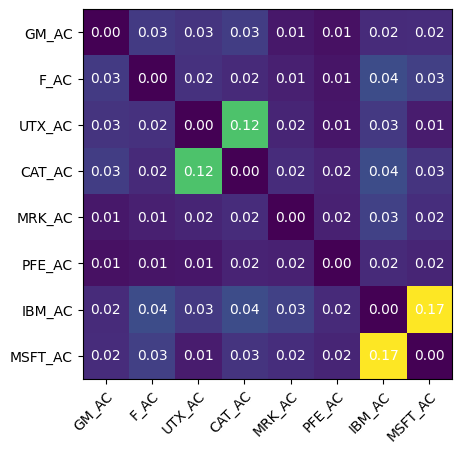

In [66]:
abs_diff_heatmap(corr_model, corr_sample)